## Grocery Price Prediction in New York City: A Machine Learning Approach

# Problem Statement:
New York City, with its diverse neighborhoods and dynamic retail landscape, presents a unique challenge in understanding grocery price variations across different retail stores. This project aims to develop a predictive model that estimates the prices of various grocery items across different stores and neighborhoods in NYC and compares them to Whole Foods' pricing. Then the project will aim to develop a predictive model capable of accurately estimating the prices of various grocery items across different stores and neighborhoods in NYC. Finally, it aims to do a separate analysis to understand price discrepancies between Whole Foods and other NYC retail stores. The project aims to use the two unique datasets (web scraped) and merge them to predict price differences based on factors such as product category, discounts, and regular price.

The successful development of this model will not only enhance predictive capabilities for grocery prices but will also empower stakeholders in the retail industry with actionable insights. Consumers can make informed decisions about where to shop, retailers can align their pricing with market trends, and policymakers can identify areas where food costs might be disproportionately high.

# Dataset Description:
The datasets used for this project is sourced from a CSV file named 'nyc_grocery_prices.csv', manually scrapped from multiple webistes of nyc retail grocery stores, providing comprehensive information about various grocery items sold in different stores across NYC neighborhoods and 'wholefood_orders.csv', manually scraped from whole foods website.

# NYC GROCERY PRICES DATASET
The dataset contains 250 rows, each representing a unique grocery item, and includes the following columns:

Store: The name of the grocery store

Neighborhood: The NYC neighborhood where the store is located

Item: The name of the grocery item

Price: The price of the item in dollars

This dataset offers a snapshot of grocery prices across the city, allowing for analysis of price variations based on store, neighborhood, and item type.

# Whole Foods Dataset

Size: 1,657 rows, each representing a unique grocery item.

Key Features:

Company: Brand or manufacturer of the product.

Product: Name of the grocery item.

Regular, Sale, Prime: Prices for different types of purchases.

Category: Type of product (e.g., pantry essentials, beverages).

Sale_discount, Prime_discount: Discount percentages for sale and Prime members.



Data Pre-Processing & Preliminary Examination


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score


In [23]:
# Load dataset
df = pd.read_csv('/content/nyc_grocery_prices.csv')
df.head()

,Date,Store,Neighborhood,Item,Price
0,2024-12-11,Whole Foods,Manhattan,Milk (Gallon),6.82
1,2024-12-11,Whole Foods,Manhattan,Bread (Loaf),2.80
2,2024-12-11,Whole Foods,Manhattan,Eggs (Dozen),3.24
3,2024-12-11,Whole Foods,Manhattan,Chicken (Pound),7.97
4,2024-12-11,Whole Foods,Manhattan,Apples (Pound),3.31


In [10]:
# 2. Descriptive Statistics
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
            Price
count  250.000000
mean     3.116040
std      1.877657
min      0.310000
25%      1.912500
50%      2.755000
75%      3.867500
max     10.350000


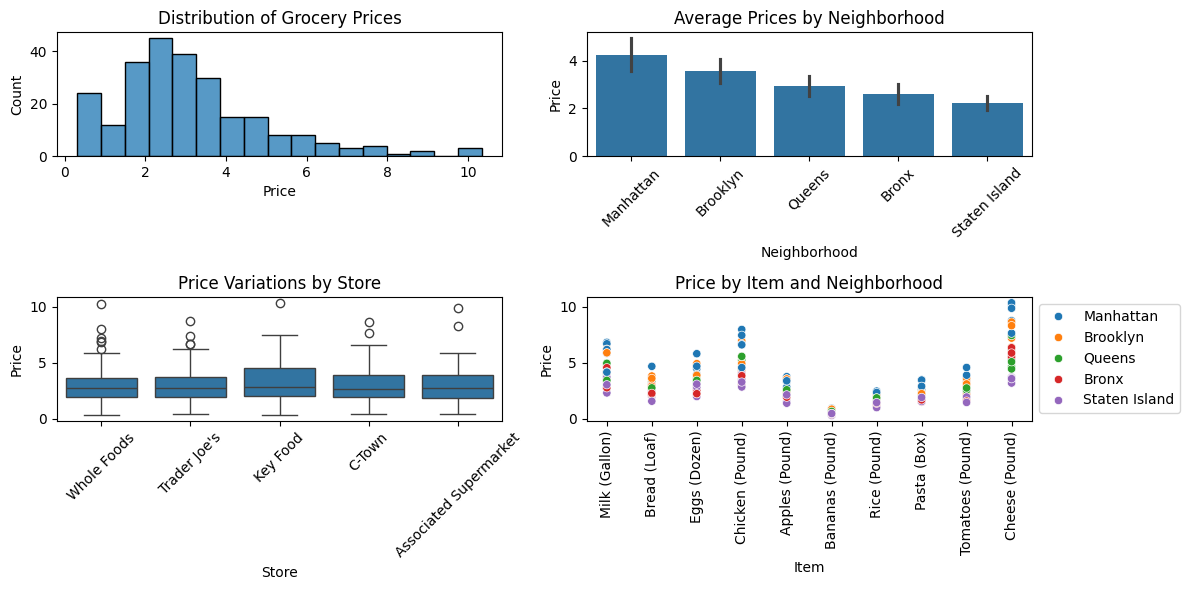

In [11]:
# Data Cleaning
# Drop any rows with null values if needed
df = df.dropna()

# Visualizations
plt.figure(figsize=(12, 6))

# 1. Distribution of Prices
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='Price')
plt.title('Distribution of Grocery Prices')

# 2. Prices by Neighborhood
plt.subplot(2, 2, 2)
sns.barplot(data=df, x='Neighborhood', y='Price')
plt.title('Average Prices by Neighborhood')
plt.xticks(rotation=45)

# 3. Prices by Store
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Store', y='Price')
plt.title('Price Variations by Store')
plt.xticks(rotation=45)

# 4 Price by Item and Neighborhood
plt.subplot(2, 2, 4)
scatter = sns.scatterplot(data=df, x='Item', y='Price', hue='Neighborhood')
plt.title('Price by Item and Neighborhood')
plt.xticks(rotation=90)

# Adjust legend position to avoid overlap
scatter.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


Average Prices by Neighborhood:
Neighborhood
Manhattan        4.2566
Brooklyn         3.5512
Queens           2.9402
Bronx            2.5916
Staten Island    2.2406
Name: Price, dtype: float64

Average Prices by Store:
Store
Key Food                  3.2628
Whole Foods               3.1402
Trader Joe's              3.1242
Associated Supermarket    3.0838
C-Town                    2.9692
Name: Price, dtype: float64


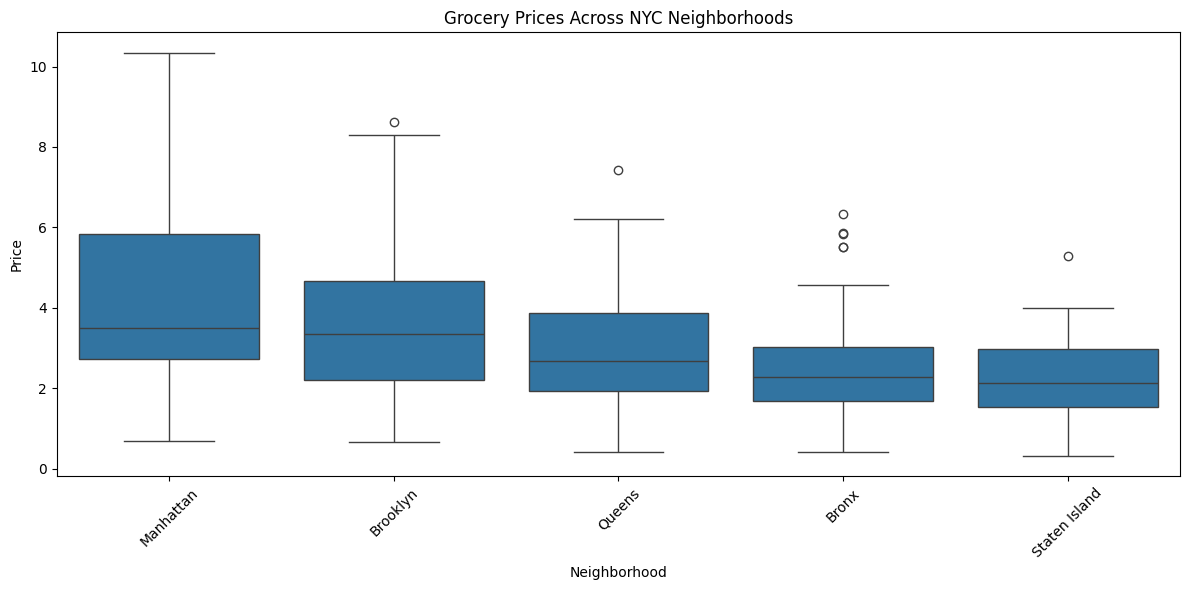

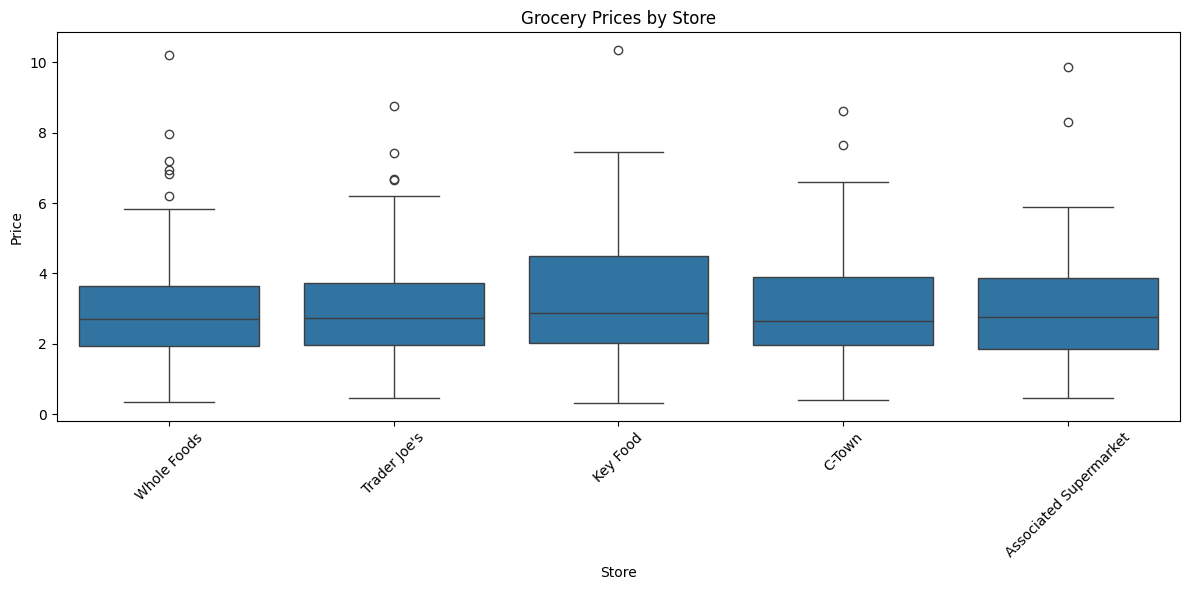

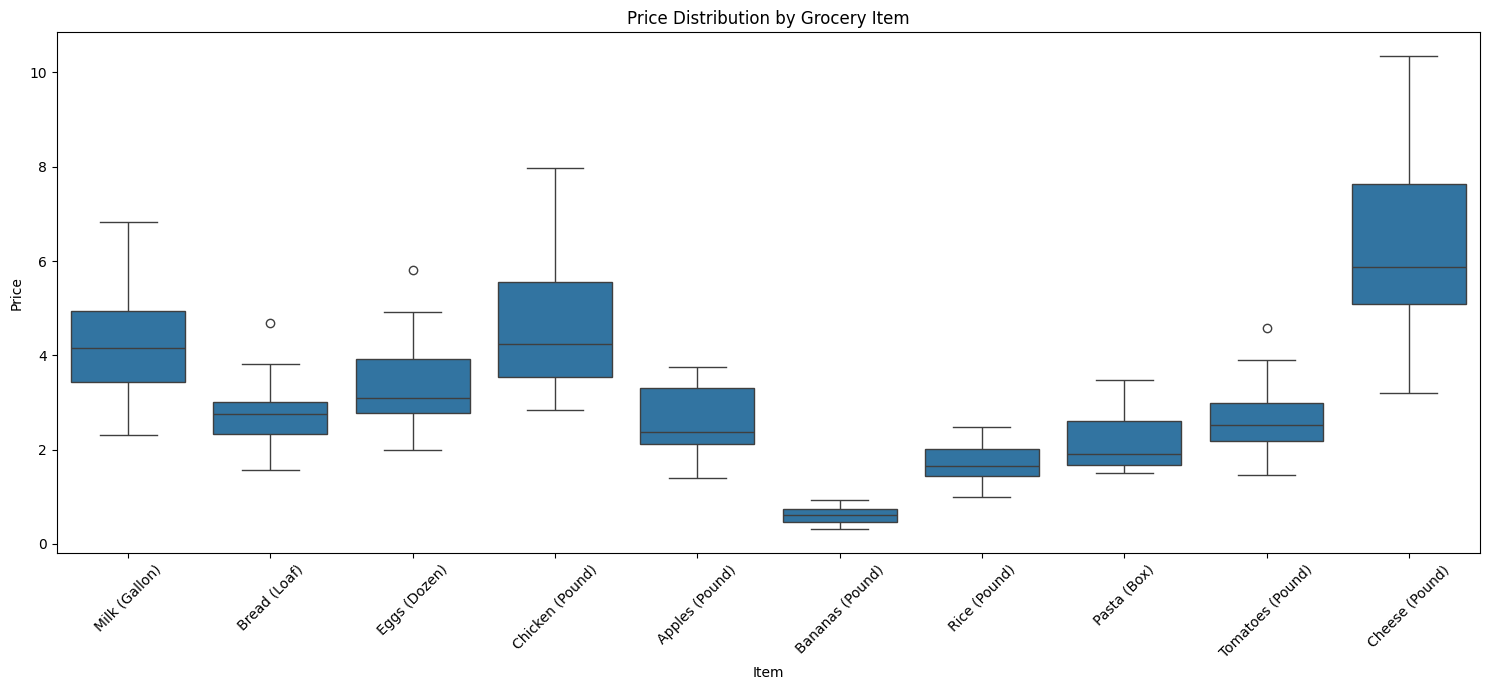

In [12]:
# 5. Price Distribution by Neighborhood
plt.figure(figsize=(12, 6))
sns.boxplot(x='Neighborhood', y='Price', data=df)
plt.title('Grocery Prices Across NYC Neighborhoods')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('neighborhood_prices.png')


# 6. Price Variation by Store
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Price', data=df)
plt.title('Grocery Prices by Store')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('store_prices.png')


# 5. Correlation Heatmap
df_encoded = pd.get_dummies(df, columns=['Store', 'Neighborhood', 'Item'])

df_encoded = df_encoded.drop(columns=['Date'])

# Correlation of prices with other features
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.close()

# 6. Average Prices Summary
avg_prices_by_neighborhood = df.groupby('Neighborhood')['Price'].mean().sort_values(ascending=False)
print("\nAverage Prices by Neighborhood:")
print(avg_prices_by_neighborhood)

avg_prices_by_store = df.groupby('Store')['Price'].mean().sort_values(ascending=False)
print("\nAverage Prices by Store:")
print(avg_prices_by_store)

# 7. Item Price Distribution
plt.figure(figsize=(15, 7))
sns.boxplot(x='Item', y='Price', data=df)
plt.title('Price Distribution by Grocery Item')
plt.xticks(rotation=45)
plt.savefig('item_prices.png')

plt.tight_layout()
plt.show()

In [29]:
# Model Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Models to evaluate
models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'K-Nearest Neighbors': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor(n_neighbors=5))
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor(random_state=42))
    ])
}

# Evaluate models
results = {}
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, X_test, y_train, y_test)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name}:")
    print(f"Mean Squared Error: {mse}")
    print(f"R² Score: {r2}\n")

# Feature Importance for Random Forest
rf_model = models['Random Forest']
rf_model.fit(X_train, y_train)
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
importances = rf_model.named_steps['regressor'].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Importance Ranking:")
for f in range(min(10, len(feature_names))):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Visualize Feature Importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances in Random Forest Model")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('feature_importances.png')
plt.close()

Linear Regression:
Mean Squared Error: 0.6577773440991534
R² Score: 0.8464598060365397

Random Forest:
Mean Squared Error: 0.6731093851999992
R² Score: 0.8428809588998941

K-Nearest Neighbors:
Mean Squared Error: 1.32965384
R² Score: 0.6896285493422446

Decision Tree:
Mean Squared Error: 0.989444
R² Score: 0.769041264435703

Feature Importance Ranking:
1. cat__Item_Cheese (Pound) (0.267635)
2. cat__Neighborhood_Manhattan (0.147806)
3. cat__Item_Bananas (Pound) (0.147800)
4. cat__Item_Chicken (Pound) (0.145994)
5. cat__Item_Milk (Gallon) (0.083555)
6. cat__Neighborhood_Staten Island (0.041650)
7. cat__Neighborhood_Brooklyn (0.035305)
8. cat__Item_Eggs (Dozen) (0.025074)
9. cat__Store_Whole Foods (0.019438)
10. cat__Store_Key Food (0.018441)


In [16]:
from sklearn.metrics import mean_squared_error

y = df['Price']
baseline_preds = np.ones(len(y)) * y.mean()
baseline_mse = mean_squared_error(y, baseline_preds)
print(f"Baseline MSE: {baseline_mse}")

Baseline MSE: 3.5114943184


In [17]:
!pip install scikit-learn

In [18]:
import sklearn

Multiple Regression Model

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Instead of "from sklearn import LinearRegression", import it specifically
from sklearn.linear_model import LinearRegression


# Prepare features and target
X = df[['Store', 'Neighborhood', 'Item']]
y = df['Price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['Store', 'Neighborhood', 'Item'])
    ])

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Store', 'Neighborhood',
                                                   'Item'])])),
                ('regressor', LinearRegression())])

In [28]:
# Make predictions and calculate MSE
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Multiple Regression - Train MSE: {train_mse}")
print(f"Multiple Regression - Test MSE: {test_mse}")

Multiple Regression - Train MSE: 0.5479000725811435
Multiple Regression - Test MSE: 0.6577773440991534


Random Forest Model

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

rf_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Store', 'Neighborhood',
                                                   'Item'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [26]:
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)

print(f"Random Forest - Train MSE: {train_mse_rf}")
print(f"Random Forest - Test MSE: {test_mse_rf}")

Random Forest - Train MSE: 0.08155388244999984
Random Forest - Test MSE: 0.6722624517999993


Feature Importace

Feature Importance Ranking:
1. cat__Item_Cheese (Pound) (0.267635)
2. cat__Neighborhood_Manhattan (0.147806)
3. cat__Item_Bananas (Pound) (0.147800)
4. cat__Item_Chicken (Pound) (0.145994)
5. cat__Item_Milk (Gallon) (0.083555)
6. cat__Neighborhood_Staten Island (0.041650)
7. cat__Neighborhood_Brooklyn (0.035305)
8. cat__Item_Eggs (Dozen) (0.025074)
9. cat__Store_Whole Foods (0.019438)
10. cat__Store_Key Food (0.018441)


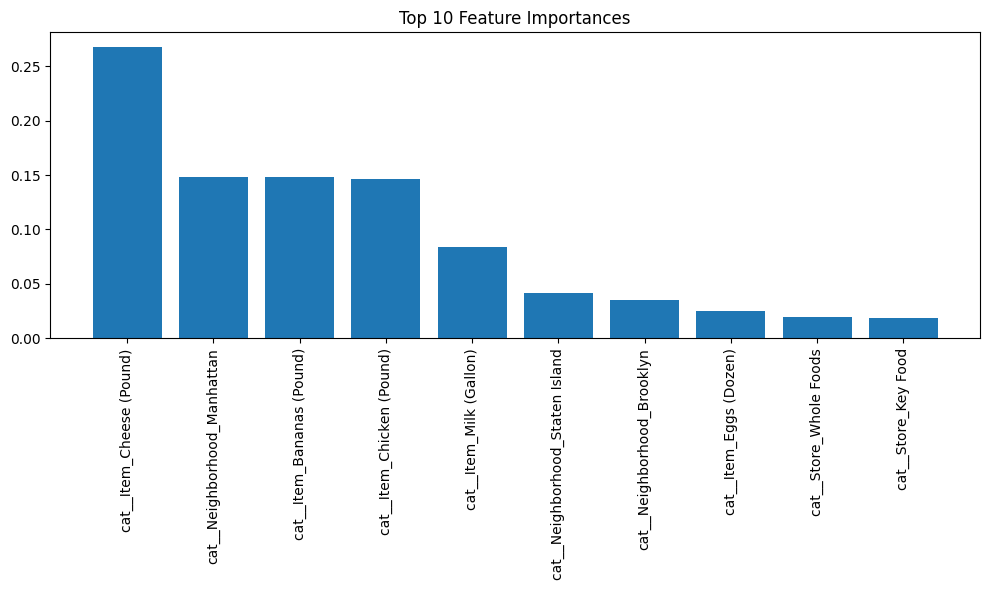

In [21]:
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()
importances = rf_model.named_steps['regressor'].feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature Importance Ranking:")
for f in range(min(10, len(feature_names))):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), [feature_names[i] for i in indices][:10], rotation=90)
plt.tight_layout()
plt.show()

# Whole food analysis

The goal of this part of the analysis is to compare grocery prices at Whole Foods and other grocery stores across New York City (NYC). By examining both datasets, I aim to understand the price discrepancies between Whole Foods and other stores. Predict price differences based on factors such as product category, discounts, and regular price. Categorize grocery items into pricing tiers (e.g., "Overpriced", "Fairly Priced", "Underpriced"). The datasets for this analysis are from Whole Foods and multiple NYC grocery stores will be merged.

In [30]:
import pandas as pd
import numpy as np

# Load the datasets
wholefoods_data = pd.read_csv('/content/wholefoodsorders.csv')
nyc_prices_data = pd.read_csv('/content/nyc_grocery_prices.csv')

# Display first few rows of each dataset
print(wholefoods_data.head())
print(nyc_prices_data.head())

   Unnamed: 0             company                            product  regular  \
0           0       CASA FORCELLO        Strawberry Balsamic Compote     9.99   
1           1  Whole Foods Market  Organic Dark Roast Steeped Coffee    11.99   
2           2              Brekki    Vanilla Cinnamon Overnight Oats     2.99   
3           3              Brekki            Original Overnight Oats     2.99   
4           4          MAD HIPPIE             Antioxidant Facial Oil    25.99   

    sale  prime           category  sale_discount  prime_discount  \
0   4.99   4.49  pantry_essentials          0.501           0.551   
1   5.99   5.39          Beverages          0.500           0.550   
2   1.50   1.35  pantry_essentials          0.498           0.548   
3   1.50   1.35  pantry_essentials          0.498           0.548   
4  14.49  13.04             beauty          0.442           0.498   

   prime_sale_difference discount_bins parsed_product  
0                  0.050   50% or more    

In [32]:
# Check data types and missing values
print(wholefoods_data.info())
print(nyc_prices_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1657 entries, 0 to 1656
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             1657 non-null   int64  
 1   company                1657 non-null   object 
 2   product                1657 non-null   object 
 3   regular                1657 non-null   float64
 4   sale                   1657 non-null   float64
 5   prime                  1657 non-null   float64
 6   category               1657 non-null   object 
 7   sale_discount          1657 non-null   float64
 8   prime_discount         1657 non-null   float64
 9   prime_sale_difference  1657 non-null   float64
 10  discount_bins          1657 non-null   object 
 11  parsed_product         1657 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 155.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 5 co

In [35]:
# Clean and standardize product names
import re
wholefoods_data['parsed_product'] = wholefoods_data['parsed_product'].str.lower().str.strip()
nyc_prices_data['Simplified_Item'] = nyc_prices_data['Item'].apply(lambda x: re.split(r'[ \(]', x.lower())[0])

# Merge datasets based on matching item descriptions
merged_data = pd.merge(wholefoods_data, nyc_prices_data, how='inner', left_on='parsed_product', right_on='Simplified_Item')

# Check the merged data
print(merged_data.head())


   Unnamed: 0            company  \
0          77  Annie's Homegrown   
1          77  Annie's Homegrown   
2          77  Annie's Homegrown   
3          77  Annie's Homegrown   
4          77  Annie's Homegrown   

                                             product  regular  sale  prime  \
0  Gluten Free Rice Shells & Creamy White Cheddar...     3.79   2.5   2.25   
1  Gluten Free Rice Shells & Creamy White Cheddar...     3.79   2.5   2.25   
2  Gluten Free Rice Shells & Creamy White Cheddar...     3.79   2.5   2.25   
3  Gluten Free Rice Shells & Creamy White Cheddar...     3.79   2.5   2.25   
4  Gluten Free Rice Shells & Creamy White Cheddar...     3.79   2.5   2.25   

            category  sale_discount  prime_discount  prime_sale_difference  \
0  pantry_essentials           0.34           0.406                  0.066   
1  pantry_essentials           0.34           0.406                  0.066   
2  pantry_essentials           0.34           0.406                  0.066   
3 

In [36]:
# I’ll create new features such as Price Difference and Percent Difference to help analyze pricing discrepancies.
# Calculate price difference and percent difference
merged_data['Price_Difference'] = merged_data['regular'] - merged_data['Price']
merged_data['Percent_Difference'] = (merged_data['Price_Difference'] / merged_data['Price']) * 100

# Display the first few rows of the merged data with new features
print(merged_data[['parsed_product', 'Price', 'regular', 'Price_Difference', 'Percent_Difference']].head())


  parsed_product  Price  regular  Price_Difference  Percent_Difference
0          pasta   2.72     3.79              1.07           39.338235
1          pasta   2.68     3.79              1.11           41.417910
2          pasta   2.57     3.79              1.22           47.470817
3          pasta   1.91     3.79              1.88           98.429319
4          pasta   1.54     3.79              2.25          146.103896


# Exploratory Data Analysis (EDA)
Initial Visualizations

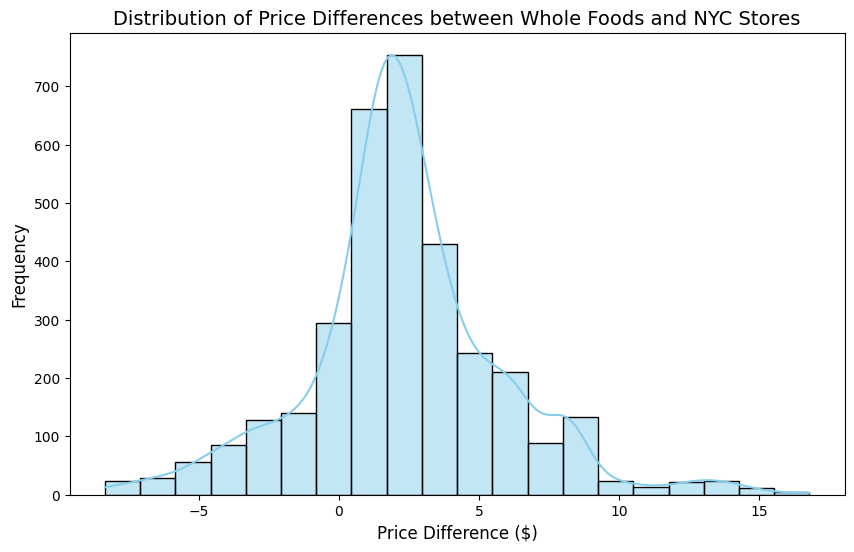

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(merged_data['Price_Difference'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Price Differences between Whole Foods and NYC Stores', fontsize=14)
plt.xlabel('Price Difference ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()


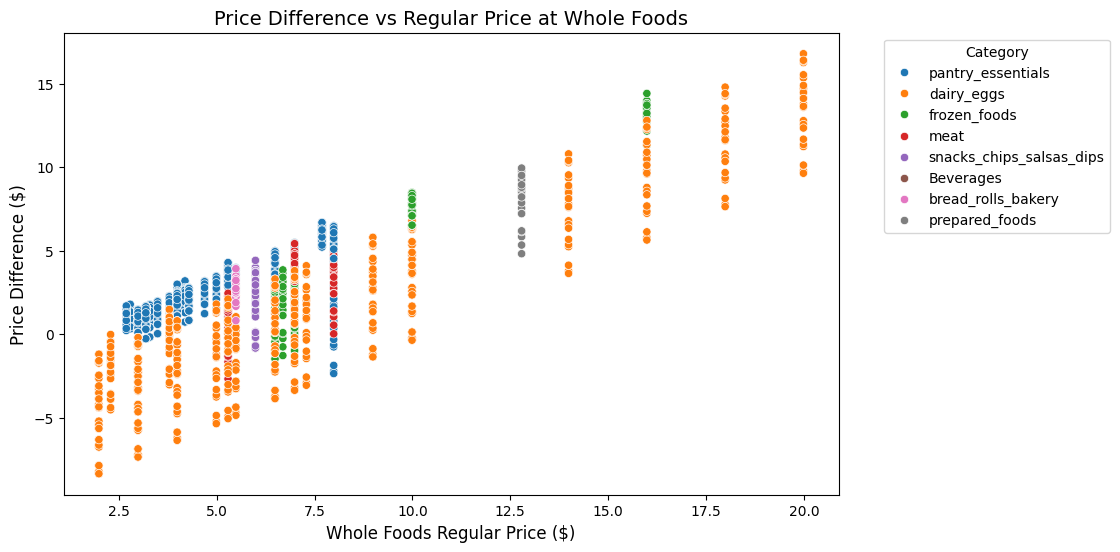

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='regular', y='Price_Difference', hue='category', palette='tab10')
plt.title('Price Difference vs Regular Price at Whole Foods', fontsize=14)
plt.xlabel('Whole Foods Regular Price ($)', fontsize=12)
plt.ylabel('Price Difference ($)', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


<ipython-input-39-19d1d3b177d8>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_data, x='category', y='Price_Difference', palette='muted')


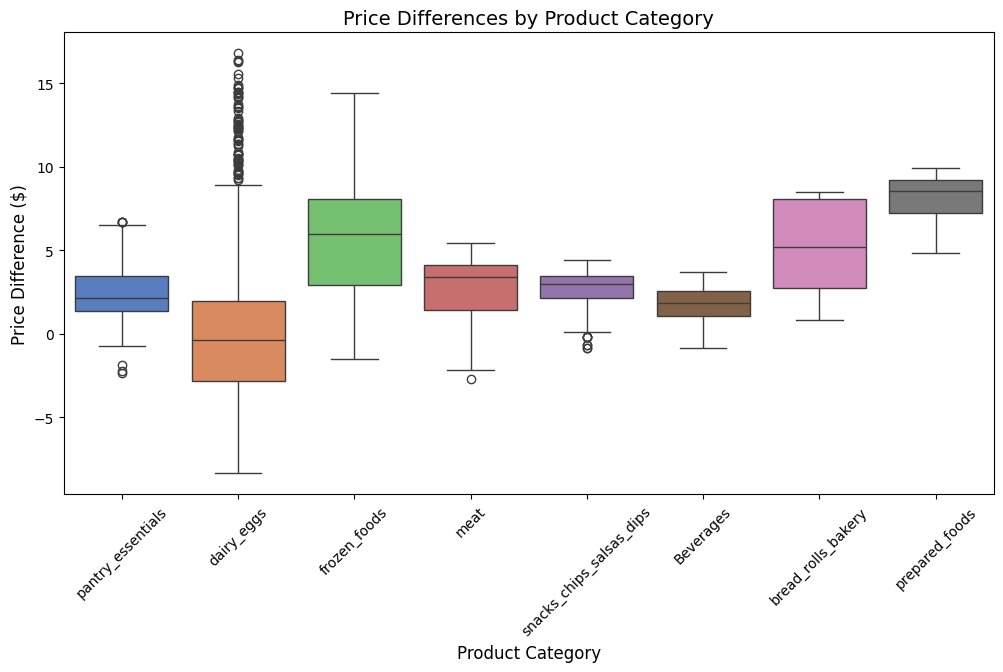

In [39]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x='category', y='Price_Difference', palette='muted')
plt.title('Price Differences by Product Category', fontsize=14)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Price Difference ($)', fontsize=12)
plt.xticks(rotation=45)
plt.show()


# Modeling and Interpretation
Baseline Model (Simple Linear Regression)

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Features and target for price difference prediction
features = ['regular', 'sale_discount', 'prime_discount']
target = 'Price_Difference'

X = merged_data[features]
y = merged_data[target]

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred = rf_regressor.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

Mean Squared Error: 2.02
R-squared: 0.83


Interpretation: R-squared will show how much variance in price differences is explained by the model, and MSE will indicate prediction accuracy.

<ipython-input-41-4d696156dc9e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')


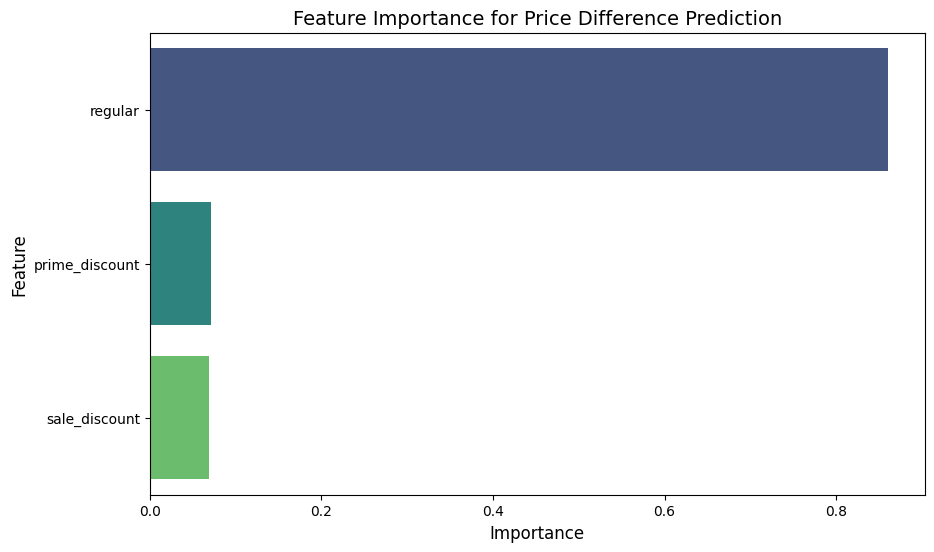

In [41]:
# Extract feature importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance for Price Difference Prediction', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.show()


Classification Report:
                precision    recall  f1-score   support

Fairly Priced       0.77      0.69      0.73       256
   Overpriced       0.84      0.91      0.87       347
  Underpriced       0.72      0.67      0.69        72

     accuracy                           0.80       675
    macro avg       0.77      0.76      0.76       675
 weighted avg       0.80      0.80      0.80       675



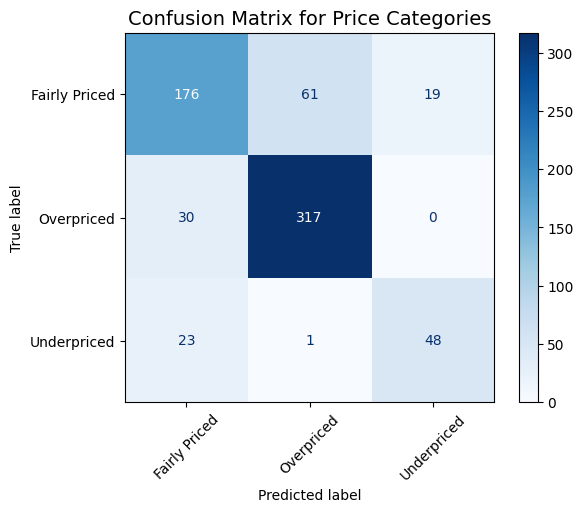

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Create price categories based on Price_Difference
def price_category(row):
    if row['Price_Difference'] > 2:
        return "Overpriced"
    elif row['Price_Difference'] < -2:
        return "Underpriced"
    else:
        return "Fairly Priced"

merged_data['Price_Category'] = merged_data.apply(price_category, axis=1)

# Features and target for classification
y = merged_data['Price_Category']

# Train-test split for classification model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_class = rf_classifier.predict(X_test)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_class))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_class, labels=rf_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_classifier.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix for Price Categories", fontsize=14)
plt.show()


In [43]:
# Prepare data
features = ['regular', 'sale_discount', 'prime_discount']
target = 'Price_Difference'

X = merged_data[features]
y = merged_data[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_regressor = RandomForestRegressor(random_state=42, n_estimators=100)
rf_regressor.fit(X_train, y_train)

# Predictions
y_pred = rf_regressor.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R-squared: {r2:.2f}")

# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': features,
    'Importance': rf_regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importances:\n", feature_importances)

Mean Squared Error: 2.02
R-squared: 0.83
Feature Importances:
           Feature  Importance
0         regular    0.860186
2  prime_discount    0.071208
1   sale_discount    0.068606
